# Transformer Results

## Imports

In [1]:
# Add Utils to path
import sys
sys.path.append('../Utils')  # Adds higher directory to python modules path.

# Utils
from datasets_generators import CocoDetection
from plot_coco_image import plot_coco_image

# Pytorch
import torch
from transformers import DetrForObjectDetection
from transformers import DetrImageProcessor

# Other
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Model 1 -  100/10/10

### Load Data

In [2]:
# Paths
imgs_path = "../ExDark_All/Images"
train_path = "../ExDark_COCO/100-20-20/train_set.json"
val_path = "../ExDark_COCO/100-20-20/val_set.json"
test_path = "../ExDark_COCO/100-20-20/test_set.json"

# Transforms
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# COCO Dataset
train_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=train_path, image_processor=image_processor)
val_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=val_path, image_processor=image_processor)
test_set = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=test_path, image_processor=image_processor)

# Labels
id2label = {k: v["name"] for k, v in train_set.coco.cats.items()}
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender']

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Load Model

In [3]:
model_path = "../Models/lightning_logs/100-20-20/"
model = DetrForObjectDetection.from_pretrained(model_path)

### Image VS Prediction

Image ID:  2 Image:  2015_00457.JPG

Annotations: 
{'id': 3, 'image_id': 2, 'category_id': 0, 'bbox': ['938', '745', '764', '756'], 'area': 577584.0} Category Label:  Bicycle
{'id': 4, 'image_id': 2, 'category_id': 9, 'bbox': ['854', '613', '143', '133'], 'area': 19019.0} Category Label:  Motorbike
{'id': 5, 'image_id': 2, 'category_id': 4, 'bbox': ['995', '579', '291', '166'], 'area': 48306.0} Category Label:  Car
{'id': 6, 'image_id': 2, 'category_id': 5, 'bbox': ['1189', '579', '330', '182'], 'area': 60060.0} Category Label:  Cat
{'id': 7, 'image_id': 2, 'category_id': 5, 'bbox': ['98', '1340', '213', '252'], 'area': 53676.0} Category Label:  Cat
{'id': 8, 'image_id': 2, 'category_id': 10, 'bbox': ['407', '1091', '369', '694'], 'area': 256086.0} Category Label:  People


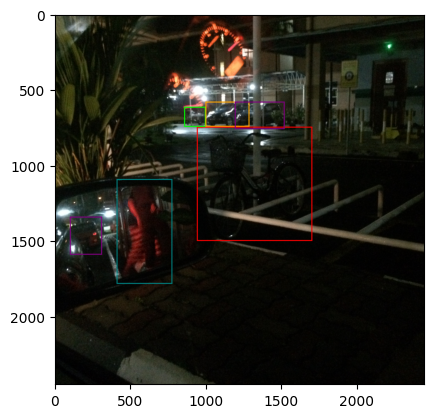

Score:  0.81263 Label:  People Box:  tensor([ 397.7890,  309.3100,  928.4623, 1748.7408])
Score:  0.22333 Label:  Bicycle Box:  tensor([ 969.5181,  763.8074, 1674.0784, 1534.2582])
Score:  0.27108 Label:  Bicycle Box:  tensor([ 979.8906,  783.4877, 1791.3635, 1546.4469])


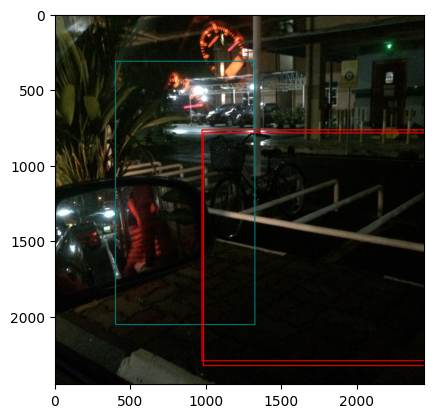

In [4]:
# Get Image
image_ids = test_set.coco.getImgIds()
image_id = 2
image = test_set.coco.loadImgs(image_id)[0]

# Load Image
img_path = os.path.join(imgs_path, image['file_name'])
image = cv2.imread(img_path)

# Plor Ground Truth
plot_coco_image(coco_dataset=test_set, imgs_path = "../ExDark_All/Images", image_id=image_id)

# Predict
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt')
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.001, 
        target_sizes=target_sizes
    )[0]

    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)

    # Keep best predictions
    for i in range(len(results["scores"])):

        if results["scores"][i] > 0.15:
            score = round(float(results["scores"][i]), 5)
            label = int(results['labels'][i])
            box = results["boxes"][i]

            print("Score: ", score, "Label: ", id2label[label], "Box: ", box)

            bbox = np.array([int(b) for b in box])
            draw.rectangle([bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]], width=7, outline=colors[label])
            draw.text([bbox[0], bbox[1]], id2label[label], fill=colors[label])
    plt.imshow(image)
    plt.show()       

### Metrics

In [5]:
# Metrics
df = pd.read_csv('../Models/lightning_logs/100-20-20/metrics.csv', header=0)

# Training loss
df_train = df[['epoch', 'training_loss']]
df_train = df_train[df_train['training_loss'].notna()]

# Validation loss
df_val = df[['epoch', 'validation/loss']]
df_val = df_val[df_val['validation/loss'].notna()]

df

,validation_loss_bbox,step,validation/loss,epoch,validation_loss_giou,validation_cardinality_error,validation_loss_ce,train_loss_giou,train_loss_ce,train_cardinality_error,training_loss,train_loss_bbox
0,0.049326,3,2.938838,0,0.239500,48.75,2.213205,NaN,NaN,NaN,NaN,NaN
1,NaN,4,NaN,1,NaN,NaN,NaN,0.246522,2.031634,45.00,3.017916,0.098648
2,0.050025,7,2.511971,1,0.235850,4.45,1.790149,NaN,NaN,NaN,NaN,NaN
3,NaN,9,NaN,2,NaN,NaN,NaN,0.170790,1.260945,2.00,1.804241,0.040343
4,0.050098,11,2.271752,2,0.242184,4.85,1.536895,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.049636,191,1.404230,47,0.249103,1.25,0.657845,NaN,NaN,NaN,NaN,NaN
86,NaN,194,NaN,48,NaN,NaN,NaN,0.041249,0.249857,0.75,0.431089,0.019747
87,0.051135,195,1.327605,48,0.244367,1.20,0.583198,NaN,NaN,NaN,NaN,NaN
88,NaN,199,NaN,49,NaN,NaN,NaN,0.063589,0.189255,0.75,0.386752,0.014064


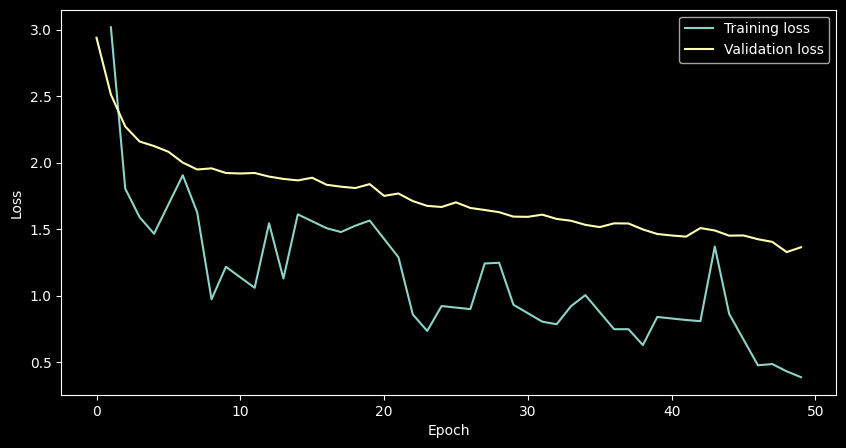

In [8]:
# Plot Loss Evolution
plt.figure(figsize=(10, 5))
plt.plot(df_train['epoch'], df_train['training_loss'], label='Training loss')
plt.plot(df_val['epoch'], df_val['validation/loss'], label='Validation loss')
plt.style.use('dark_background')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()